# Regression model to predict the delivery time (in minutes) for an e-commerce platform. (Random Forest Regressor)

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import matplotlib.pyplot as plt

# Read Data

In [3]:
df = pd.read_csv('delivery_data.csv')
df.head(5)

,timestamp,distance_km,weather_condition,traffic_level,package_weight,driver_rating,delivery_time_minutes
0,2023-01-11 23:15:00,6.4,Sunny,Low,-1.0,NaN,33.0
1,2023-01-01 14:20:00,7.9,Sunny,High,25.0,3.7,46.0
2,2023-01-27 11:58:00,13.3,Sunny,Medium,25.3,3.8,46.0
3,2023-02-01 01:32:00,11.8,Sunny,Low,11.5,4.2,30.0
4,2023-01-08 20:04:00,7.8,Rainy,Low,19.1,4.6,42.0


In [4]:
df.shape

(1000, 7)

In [5]:
df.info(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   timestamp              1000 non-null   object 
 1   distance_km            1000 non-null   float64
 2   weather_condition      1000 non-null   object 
 3   traffic_level          1000 non-null   object 
 4   package_weight         1000 non-null   float64
 5   driver_rating          950 non-null    float64
 6   delivery_time_minutes  1000 non-null   float64
dtypes: float64(4), object(3)
memory usage: 54.8+ KB


# Extract Feature 1
Extract hours from timestamp

In [7]:
df['hours'] = pd.to_datetime(df['timestamp']).dt.hour
df['hours']

0      23
1      14
2      11
3       1
4      20
       ..
995    11
996    22
997     3
998    16
999     1
Name: hours, Length: 1000, dtype: int32

# Extract Feature 2
Detect weekend or weekday

In [9]:
df['day'] = pd.to_datetime(df['timestamp']).dt.day
df['day']

0      11
1       1
2      27
3       1
4       8
       ..
995     9
996    11
997    17
998     5
999    12
Name: day, Length: 1000, dtype: int32

In [10]:
df['is_weekday'] = (
    (df['day'] == 1) |
    (df['day'] == 2) |
    ((df['day'] >= 5) & (df['day'] <= 9)) |
    ((df['day'] >= 12) & (df['day'] <= 16)) |
    ((df['day'] >= 19) & (df['day'] <= 23)) |
    ((df['day'] >= 26) & (df['day'] <= 30))
).astype(int)

In [11]:
df['is_weekday']
# 1 > Weekday, 0 > Weekend

0      0
1      1
2      1
3      1
4      1
      ..
995    1
996    0
997    0
998    1
999    1
Name: is_weekday, Length: 1000, dtype: int32

# Drop timestamp

In [13]:
df = df.drop(columns = ['timestamp'])

In [14]:
df

,distance_km,weather_condition,traffic_level,package_weight,driver_rating,delivery_time_minutes,hours,day,is_weekday
0,6.4,Sunny,Low,-1.0,NaN,33.0,23,11,0
1,7.9,Sunny,High,25.0,3.7,46.0,14,1,1
2,13.3,Sunny,Medium,25.3,3.8,46.0,11,27,1
3,11.8,Sunny,Low,11.5,4.2,30.0,1,1,1
4,7.8,Rainy,Low,19.1,4.6,42.0,20,8,1
...,...,...,...,...,...,...,...,...,...
995,6.8,Sunny,High,11.1,4.8,51.0,11,9,1
996,6.0,Sunny,Medium,9.6,4.6,20.0,22,11,0
997,7.8,Sunny,High,6.3,4.0,44.0,3,17,0
998,2.7,Rainy,High,20.5,4.9,47.0,16,5,1


# Data Set Splitting

In [16]:
X = df.drop(['delivery_time_minutes'], axis=1)
y = df['delivery_time_minutes']

In [17]:
missing_value = X.isnull().sum()
missing_value

distance_km           0
weather_condition     0
traffic_level         0
package_weight        0
driver_rating        50
hours                 0
day                   0
is_weekday            0
dtype: int64

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Pipeline Building

In [20]:
categorical_data = X.select_dtypes(include=['object']).columns

In [21]:
null_processor = Pipeline(steps=[('imputer', SimpleImputer(strategy='median'))])
categorical_processor = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [22]:
processor = ColumnTransformer(
    transformers=[
        ('driver_rating', null_processor, ['driver_rating']),
        ('catgorical', categorical_processor, categorical_data)
    ],
    remainder='passthrough'
)

In [23]:
regressor = Pipeline(
    steps=[
        ('processor', processor),
        ('regressor', RandomForestRegressor(n_estimators=10, random_state=0))
    ]
)

# Model Fitting

In [25]:
regressor.fit(X_train, y_train)

C:\Users\user\anaconda3\Lib\site-packages\sklearn\compose\_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('processor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('driver_rating',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['driver_rating']),
                                                 ('catgorical',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['weather_condition', 'traffic_level'], dtype='object'))])),
                ('regressor',
                 RandomForestRegressor(n_estimators=10, random_state=0))])

In [26]:
y_pred = regressor.predict(X_test)

In [27]:
#X_train_processed = regressor.named_steps['processor'].transform(X_train)

In [28]:
# Model Accuracy

In [29]:
mae = mean_absolute_error(y_test, y_pred)
print("MAE", mae)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE", rmse)

r2 = r2_score(y_test, y_pred)
print("R2", r2)

MAE 4.6385000000000005
RMSE 5.811587562792115
R2 0.840587862214631


# Visualization

In [31]:
ori_10 = y_test.iloc[:10]
pred_10 = y_pred[:10]

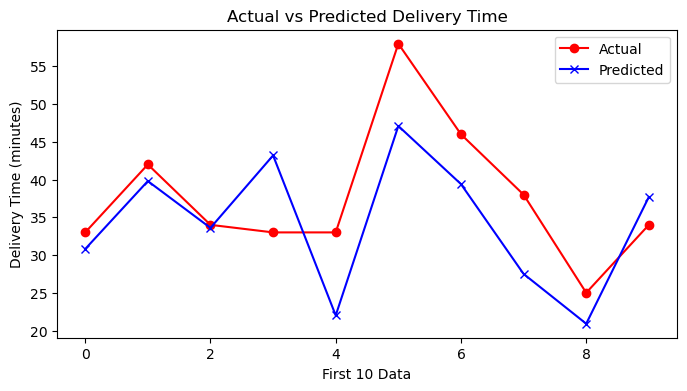

In [32]:
plt.figure(figsize=(8, 4))

plt.plot(ori_10.values, marker='o', label='Actual', color='red')
plt.plot(pred_10, marker='x', label='Predicted', color='blue')

plt.xlabel("First 10 Data")
plt.ylabel("Delivery Time (minutes)")
plt.title("Actual vs Predicted Delivery Time")
plt.legend()

plt.show()